In [2]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# %cd /content/drive/MyDrive/Colab Notebooks/Disertasi-Ahmad-Rofiqul/002.Experiment_SWI_16052024/

In [23]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.svm import OneClassSVM

In [24]:
# Load the dataset
file_path = '01.Dataset-Rofiqul/012_N2O_Soft_Voting_agriculture_dataset.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset for review
# data.head(), data.info()

##  Missing Value Handling

In [5]:
# missing_values_count = data.isna().sum()
# missing_values_count

## Prepare Train Test Split

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns


In [7]:
# Encode categorical variables if any
label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])

# Split the data into features and target variable
X = data.drop(columns=['N2O'])
y = data['N2O']


## First Initial Training Testing Data Split and XGBoost Prediction

In [8]:
#MANUAL TESTING TRAINING SPLIT
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display shapes of the training and testing sets
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1796, 29) (450, 29) (1796,) (450,)


## XGBoost with DMatrix Format

In [9]:
# Convert the data to DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

## XGBoost with K-Fold CV

In [25]:
from xgboost import cv

# Define the model parameters
params = {
    "objective": "reg:squarederror",  # Use regression objective for N2O prediction
    'colsample_bytree': 0.3,
    'learning_rate': 0.1,
    'max_depth': 5,
    'alpha': 10
}

In [26]:
# Perform cross-validation
xgb_cv = cv(dtrain=dtrain, params=params, nfold=3, num_boost_round=50, 
            early_stopping_rounds=10, metrics="rmse", as_pandas=True, seed=123)

# Display cross-validation results
print(xgb_cv)

    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0          0.932588        0.069115        0.922906       0.163291
1          0.884966        0.066857        0.874437       0.169323
2          0.844180        0.065022        0.832855       0.173303
3          0.814038        0.065672        0.816872       0.171521
4          0.781241        0.064364        0.784890       0.172402
5          0.755665        0.062206        0.769366       0.175574
6          0.729691        0.054487        0.757703       0.174039
7          0.704668        0.050788        0.738415       0.169402
8          0.681550        0.050101        0.721194       0.177392
9          0.664939        0.048745        0.714321       0.175028
10         0.642077        0.047562        0.700177       0.179194
11         0.626994        0.046441        0.691277       0.184683
12         0.608692        0.042471        0.680240       0.178825
13         0.593802        0.041256        0.677192       0.17

In [27]:
# Train the final model using the best number of boosting rounds from cross-validation
best_num_boost_rounds = xgb_cv.shape[0]
model = xgb.train(params, dtrain, num_boost_round=best_num_boost_rounds)


Mean Squared Error: 0.21643480271105042
Root Mean Squared Error: 0.46522553961605595
Mean Absolute Error: 0.1667228170873323
R-squared: 0.815687668333269


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


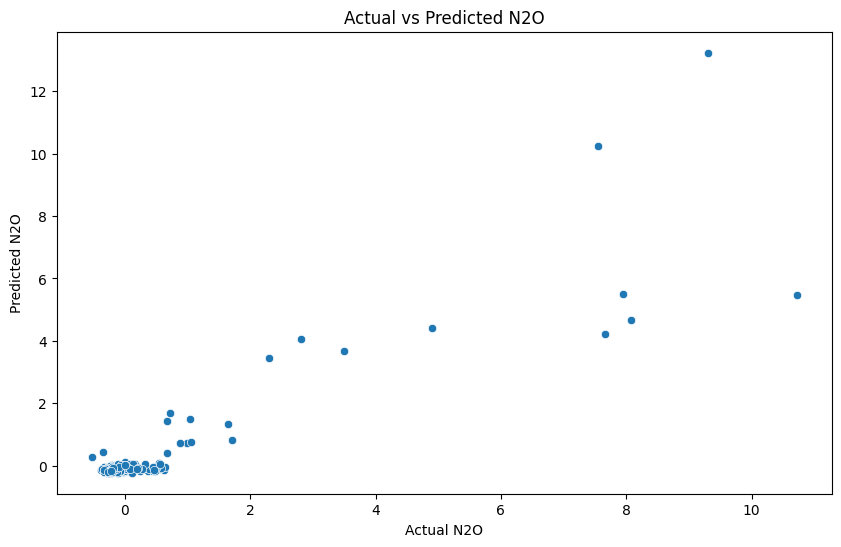

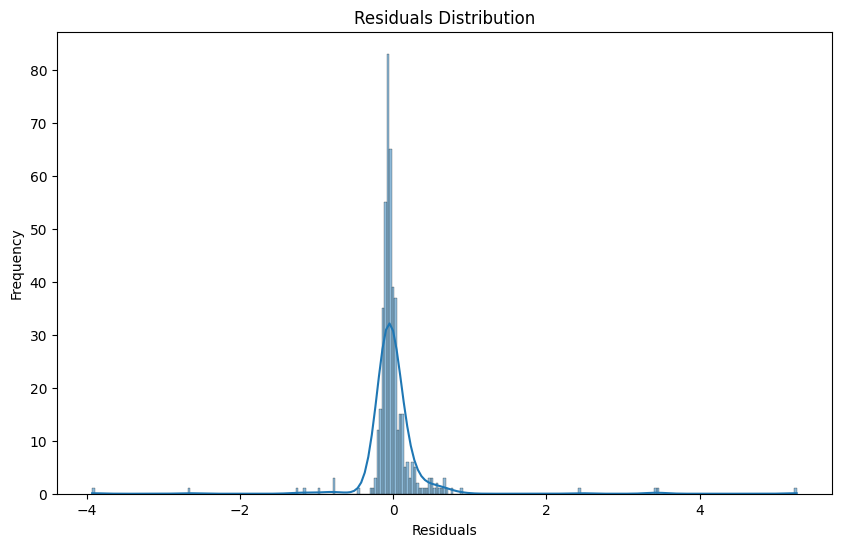

<Figure size 1000x600 with 0 Axes>

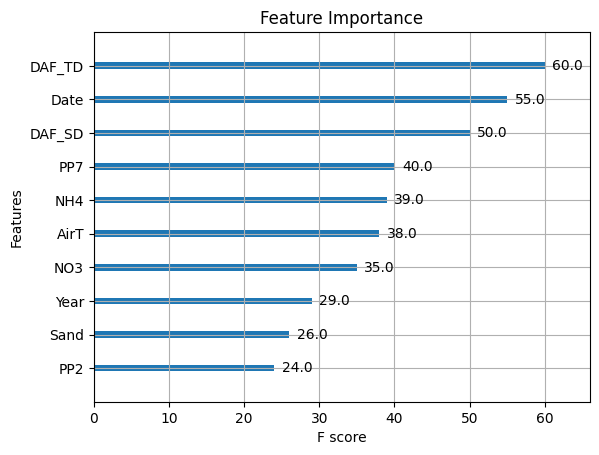

In [29]:
# Make predictions on the test set
y_pred = model.predict(dtest)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")

# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel('Actual N2O')
plt.ylabel('Predicted N2O')
plt.title('Actual vs Predicted N2O')
plt.show()

# Plot residuals
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.show()

# Plot feature importance
plt.figure(figsize=(10, 6))
xgb.plot_importance(model, max_num_features=10)
plt.title('Feature Importance')
plt.show()

## Standard XGBoost

In [19]:
# Define the model parameters
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.1,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}
# Train the model
num_boost_round = 100
model = xgb.train(params, dtrain, num_boost_round)

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Mean Squared Error: 0.475661041597362
Root Mean Squared Error: 0.68968184084936
Mean Absolute Error: 0.16165856082486527
R-squared: 0.5949348507648324


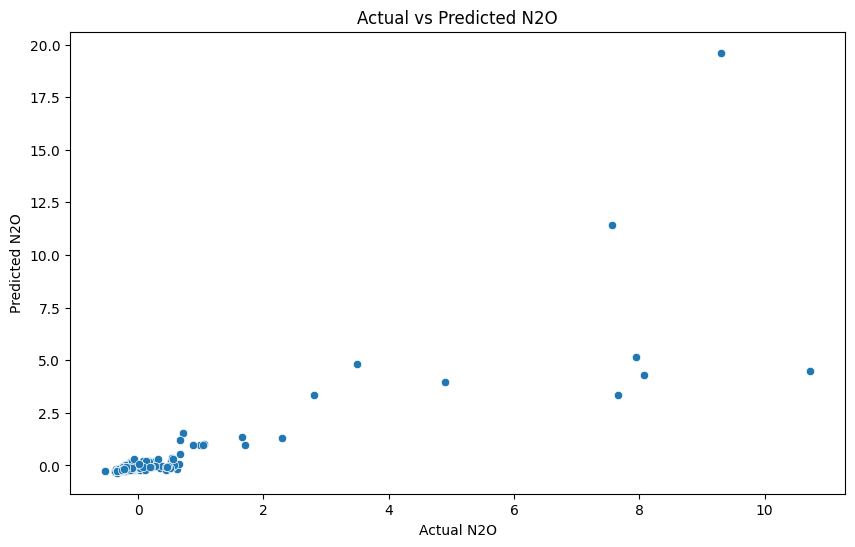

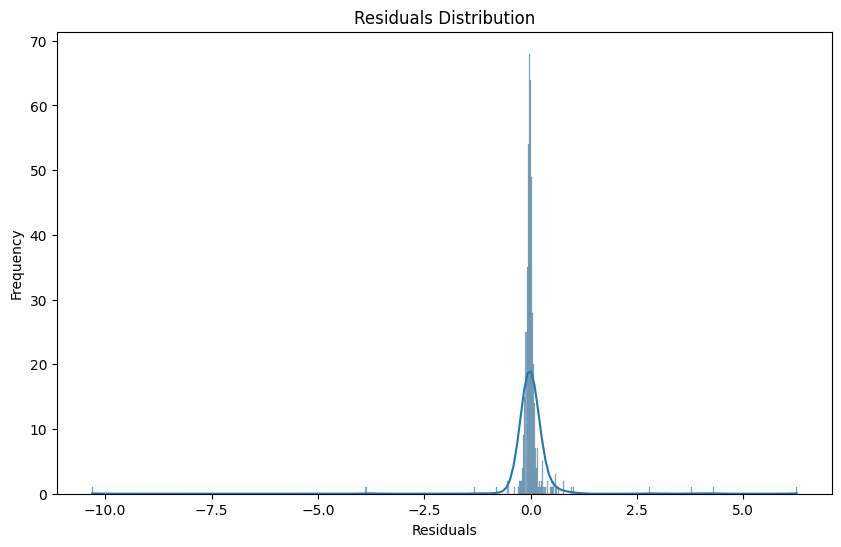

<Figure size 1000x600 with 0 Axes>

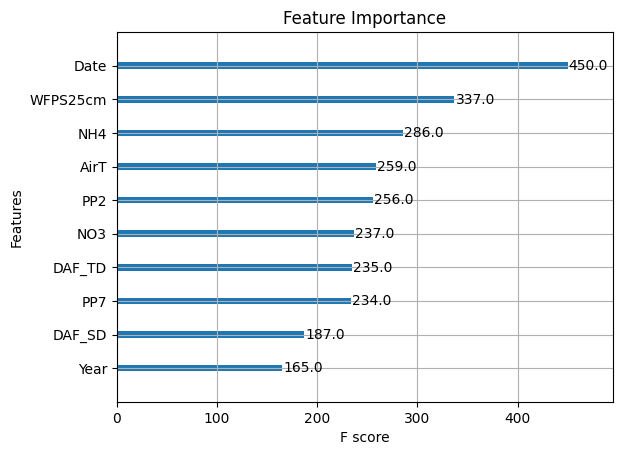

In [20]:
# Make predictions on the test set
y_pred = model.predict(dtest)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")

# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel('Actual N2O')
plt.ylabel('Predicted N2O')
plt.title('Actual vs Predicted N2O')
plt.show()

# Plot residuals
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.show()

# Plot feature importance
plt.figure(figsize=(10, 6))
xgb.plot_importance(model, max_num_features=10)
plt.title('Feature Importance')
plt.show()

## Standard XGBoost

In [21]:
# Initialize the XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

Mean Squared Error: 0.5149188796794761
Root Mean Squared Error: 0.7175784832890937


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


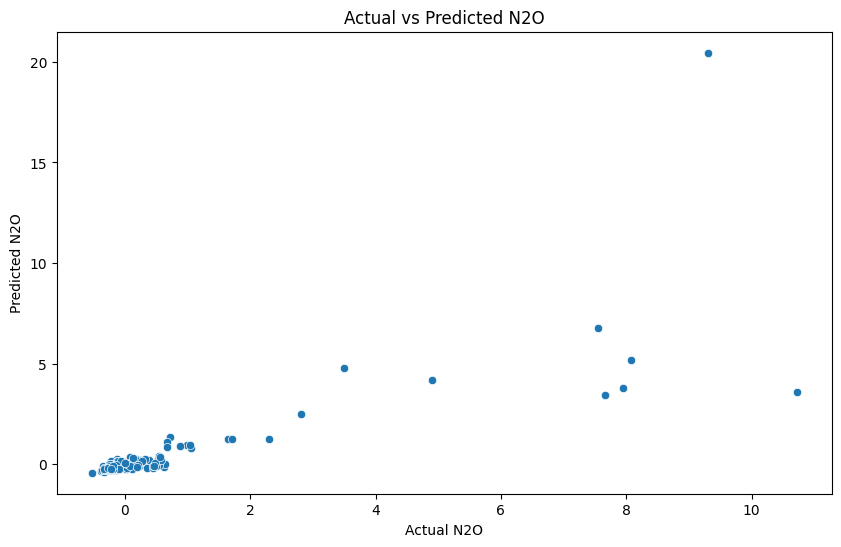

<Figure size 1000x600 with 0 Axes>

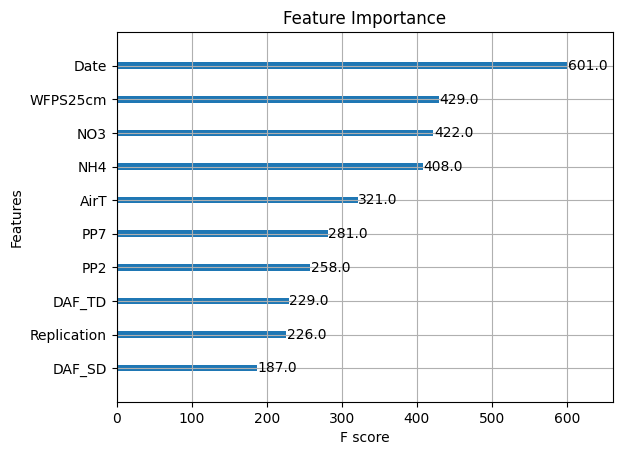

In [22]:
# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel('Actual N2O')
plt.ylabel('Predicted N2O')
plt.title('Actual vs Predicted N2O')
plt.show()

# Plot feature importance
plt.figure(figsize=(10, 6))
xgb.plot_importance(model, max_num_features=10)
plt.title('Feature Importance')
plt.show()

Test Size: 0.2
Mean Squared Error: 0.5149188796794761
Root Mean Squared Error: 0.7175784832890937
Mean Absolute Error: 0.15860714883675275
R-squared: 0.5615035191006296


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


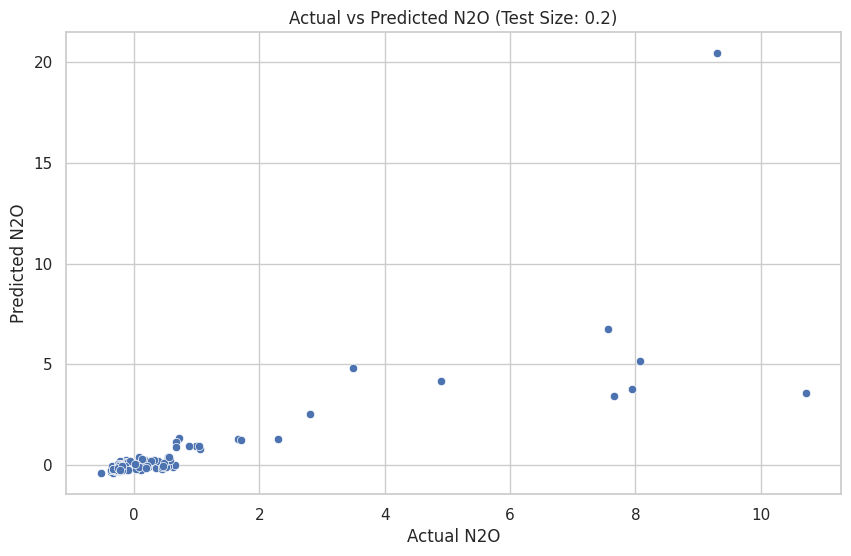

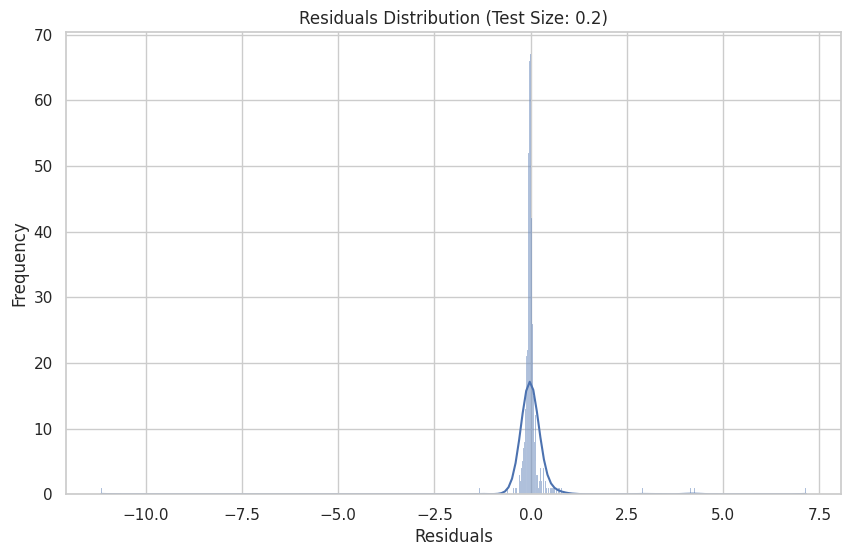

Test Size: 0.25
Mean Squared Error: 0.4098570139643107
Root Mean Squared Error: 0.6402007606714558
Mean Absolute Error: 0.14119190652898125
R-squared: 0.5712032047811703


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


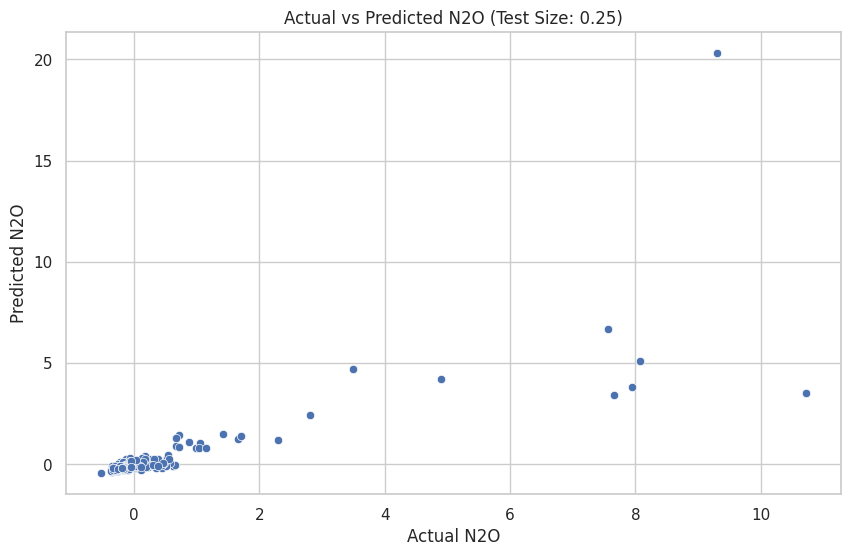

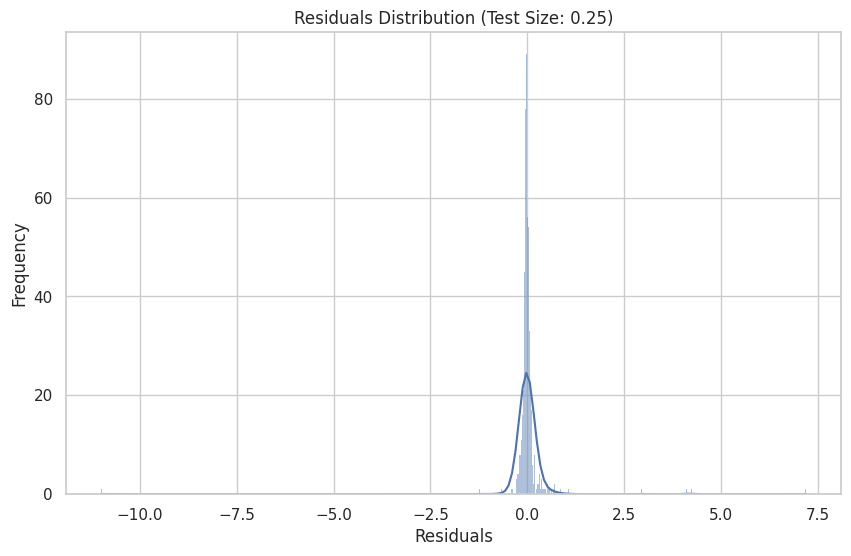

Test Size: 0.3
Mean Squared Error: 0.8040487047783644
Root Mean Squared Error: 0.8966876294331066
Mean Absolute Error: 0.16796820940932417
R-squared: 0.08417399424875849


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


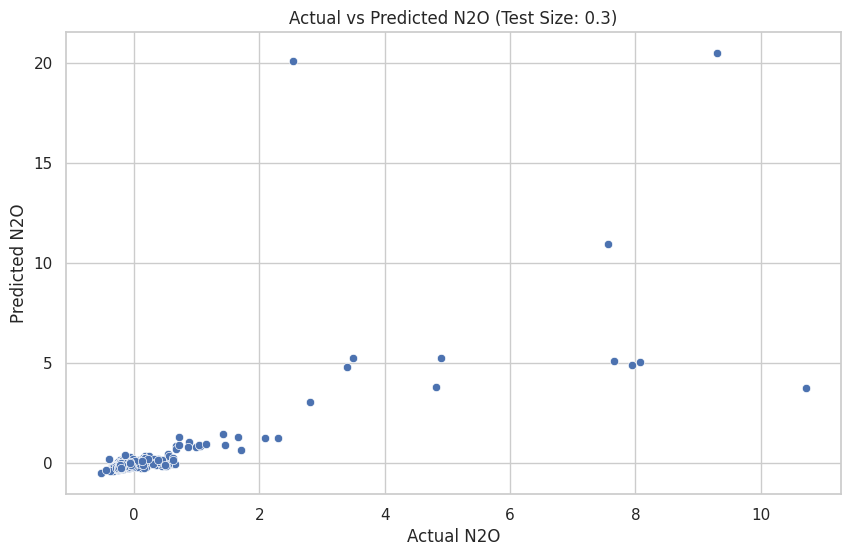

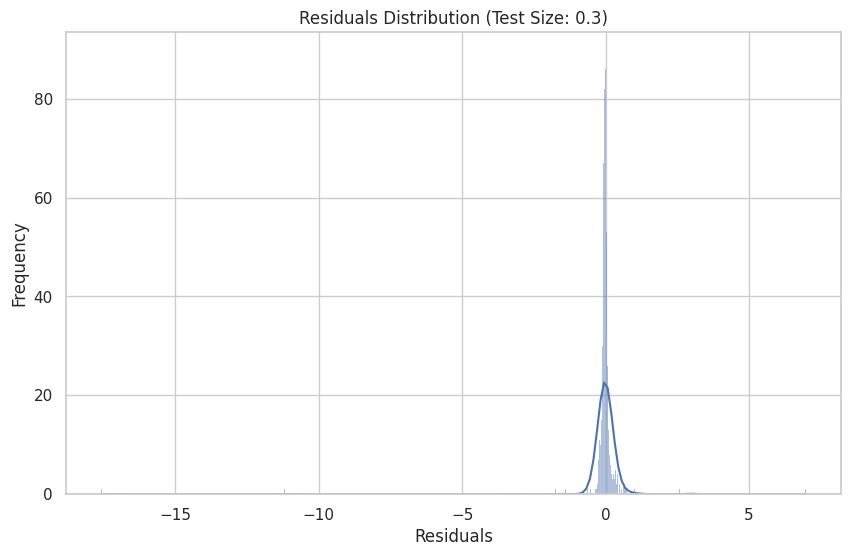

Test Size: 0.35
Mean Squared Error: 0.7960632838229277
Root Mean Squared Error: 0.8922237857303109
Mean Absolute Error: 0.17723168987118126
R-squared: 0.44242054699472877


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


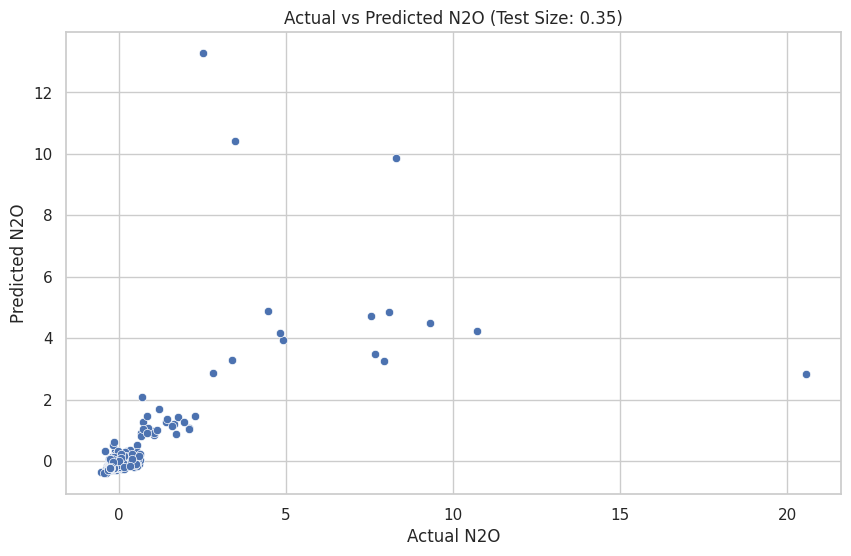

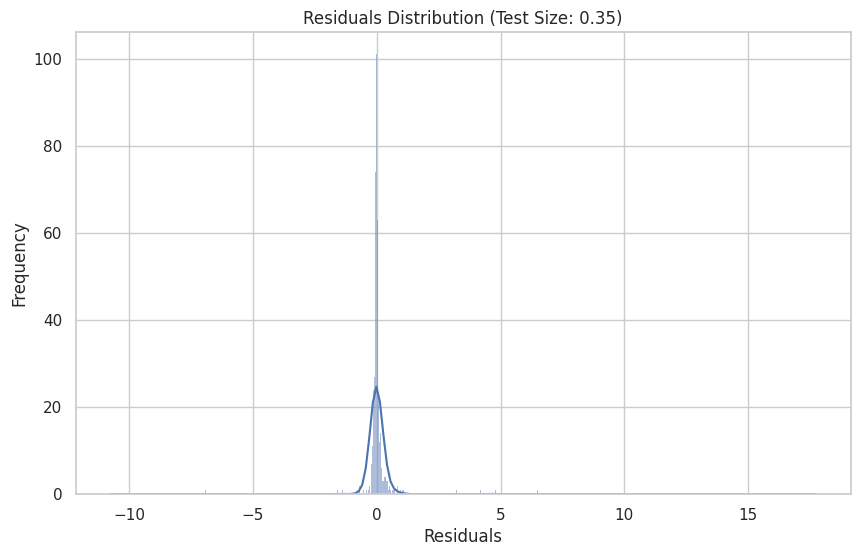

Test Size: 0.2
Mean Squared Error: 0.5149188796794761
Root Mean Squared Error: 0.7175784832890937
Mean Absolute Error: 0.15860714883675275
R-squared: 0.5615035191006296


Test Size: 0.25
Mean Squared Error: 0.4098570139643107
Root Mean Squared Error: 0.6402007606714558
Mean Absolute Error: 0.14119190652898125
R-squared: 0.5712032047811703


Test Size: 0.3
Mean Squared Error: 0.8040487047783644
Root Mean Squared Error: 0.8966876294331066
Mean Absolute Error: 0.16796820940932417
R-squared: 0.08417399424875849


Test Size: 0.35
Mean Squared Error: 0.7960632838229277
Root Mean Squared Error: 0.8922237857303109
Mean Absolute Error: 0.17723168987118126
R-squared: 0.44242054699472877




" # # Loop through each test size, train and evaluate the model, and store the results\nfor test_size in test_sizes:\n    result = train_evaluate_tuning(test_size)\n    results.append(result)\n\n# Convert results to a DataFrame\nresults_df = pd.DataFrame(results)\n\n# Save the results to a CSV file\nresults_df.to_csv('01.Dataset-Rofiqul/015_xgboost_evaluation_results.csv', index=False) "

In [23]:
test_sizes = [0.2,0.25, 0.3, 0.35]
results = {}
# Initialize an empty list to store results
evaluation = []

def train_and_evaluate(test_size):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # Initialize the XGBoost model
    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model's performance
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Test Size: {test_size}")
    print(f"Mean Squared Error: {mse}")
    print(f"Root Mean Squared Error: {rmse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"R-squared: {r2}")

    # Plot the actual vs predicted values
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_test, y=y_pred)
    plt.xlabel('Actual N2O')
    plt.ylabel('Predicted N2O')
    plt.title(f'Actual vs Predicted N2O (Test Size: {test_size})')
    plt.show()

    # Plot residuals
    residuals = y_test - y_pred
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True)
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title(f'Residuals Distribution (Test Size: {test_size})')
    plt.show()

    return model, mse, rmse, mae, r2

for test_size in test_sizes:
    model, mse, rmse, mae, r2 = train_and_evaluate(test_size)
    results[test_size] = {'model': model, 'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2}
    evaluation.append({
        'test_size': test_size,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    })
# Convert results to a DataFrame
eval_df = pd.DataFrame(evaluation)

# Save the results to a CSV file
eval_df.to_csv('01.Dataset-Rofiqul/014_xgboost_evaluation_results.csv', index=False)


# Display the results
for test_size, metrics in results.items():
    print(f"Test Size: {test_size}")
    print(f"Mean Squared Error: {metrics['mse']}")
    print(f"Root Mean Squared Error: {metrics['rmse']}")
    print(f"Mean Absolute Error: {metrics['mae']}")
    print(f"R-squared: {metrics['r2']}")
    print("\n")



""" # # Loop through each test size, train and evaluate the model, and store the results
for test_size in test_sizes:
    result = train_evaluate_tuning(test_size)
    results.append(result)

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Save the results to a CSV file
results_df.to_csv('01.Dataset-Rofiqul/015_xgboost_evaluation_results.csv', index=False) """

# Display the results DataFrame
# print(results_df)

In [14]:
eval_df

,test_size,mse,rmse,mae,r2
0,0.20,0.514919,0.717578,0.158607,0.561504
1,0.25,0.409857,0.640201,0.141192,0.571203
2,0.30,0.804049,0.896688,0.167968,0.084174
3,0.35,0.796063,0.892224,0.177232,0.442421


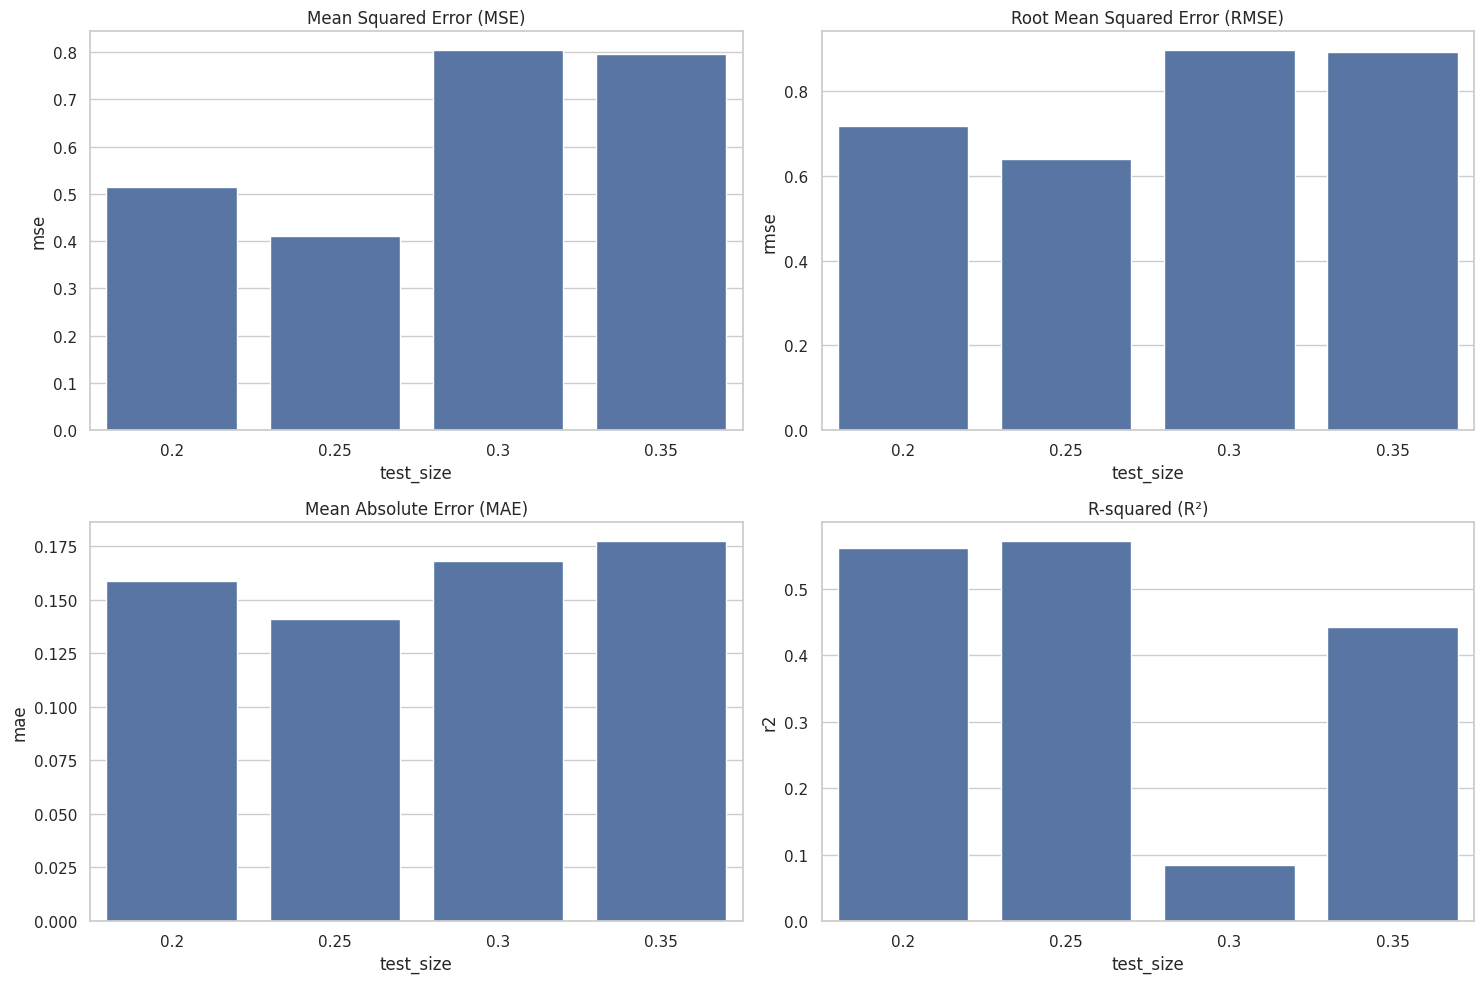

In [15]:
# Set the style of the visualization
sns.set(style="whitegrid")

# Create a figure and a set of subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot MSE
sns.barplot(x='test_size', y='mse', data=eval_df, ax=axs[0, 0])
axs[0, 0].set_title('Mean Squared Error (MSE)')

# Plot RMSE
sns.barplot(x='test_size', y='rmse', data=eval_df, ax=axs[0, 1])
axs[0, 1].set_title('Root Mean Squared Error (RMSE)')

# Plot MAE
sns.barplot(x='test_size', y='mae', data=eval_df, ax=axs[1, 0])
axs[1, 0].set_title('Mean Absolute Error (MAE)')

# Plot R-squared
sns.barplot(x='test_size', y='r2', data=eval_df, ax=axs[1, 1])
axs[1, 1].set_title('R-squared (R²)')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [16]:
# Identify the best evaluation based on the lowest MSE
best_evaluation = eval_df.loc[eval_df['mse'].idxmin()]

# Print the best evaluation result
print("Best Evaluation Result:")
print(best_evaluation)

Best Evaluation Result:
test_size    0.250000
mse          0.409857
rmse         0.640201
mae          0.141192
r2           0.571203
Name: 1, dtype: float64


In [26]:
from sklearn.model_selection import train_test_split, cross_val_score

## XGBoost with Cross Validation

In [27]:
def crossval_evaluate(test_size, n_splits=5):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # Initialize the XGBoost model
    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

    # Perform cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=n_splits, scoring='neg_mean_squared_error')
    
    # Train the model on the entire training data
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model's performance
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Test Size: {test_size}, Cross-Validation MSE: {-cv_scores.mean()}")
    print(f"Mean Squared Error: {mse}")
    print(f"Root Mean Squared Error: {rmse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"R-squared: {r2}")

    return {
        'test_size': test_size,
        'cv_mse': -cv_scores.mean(),
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }

In [28]:
# Define test sizes
test_sizes = [0.2, 0.25, 0.3, 0.35]

# Initialize an empty list to store results
results = []

# Loop through each test size, train and evaluate the model, and store the results
for test_size in test_sizes:
    result = crossval_evaluate(test_size)
    results.append(result)

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Save the results to a CSV file
results_df.to_csv('01.Dataset-Rofiqul/016_xgboost_crossval_evaluation_results.csv', index=False)

# Display the results DataFrame
print(results_df)

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test Size: 0.2, Cross-Validation MSE: 0.6933898537682792
Mean Squared Error: 0.5149188796794761
Root Mean Squared Error: 0.7175784832890937
Mean Absolute Error: 0.15860714883675275
R-squared: 0.5615035191006296


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test Size: 0.25, Cross-Validation MSE: 0.744705686709928
Mean Squared Error: 0.4098570139643107
Root Mean Squared Error: 0.6402007606714558
Mean Absolute Error: 0.14119190652898125
R-squared: 0.5712032047811703


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test Size: 0.3, Cross-Validation MSE: 0.5842360260654849
Mean Squared Error: 0.8040487047783644
Root Mean Squared Error: 0.8966876294331066
Mean Absolute Error: 0.16796820940932417
R-squared: 0.08417399424875849
Test Size: 0.35, Cross-Validation MSE: 0.2963437590228677
Mean Squared Error: 0.7960632838229277
Root Mean Squared Error: 0.8922237857303109
Mean Absolute Error: 0.17723168987118126
R-squared: 0.44242054699472877
   test_size    cv_mse       mse      rmse       mae        r2
0       0.20  0.693390  0.514919  0.717578  0.158607  0.561504
1       0.25  0.744706  0.409857  0.640201  0.141192  0.571203
2       0.30  0.584236  0.804049  0.896688  0.167968  0.084174
3       0.35  0.296344  0.796063  0.892224  0.177232  0.442421


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


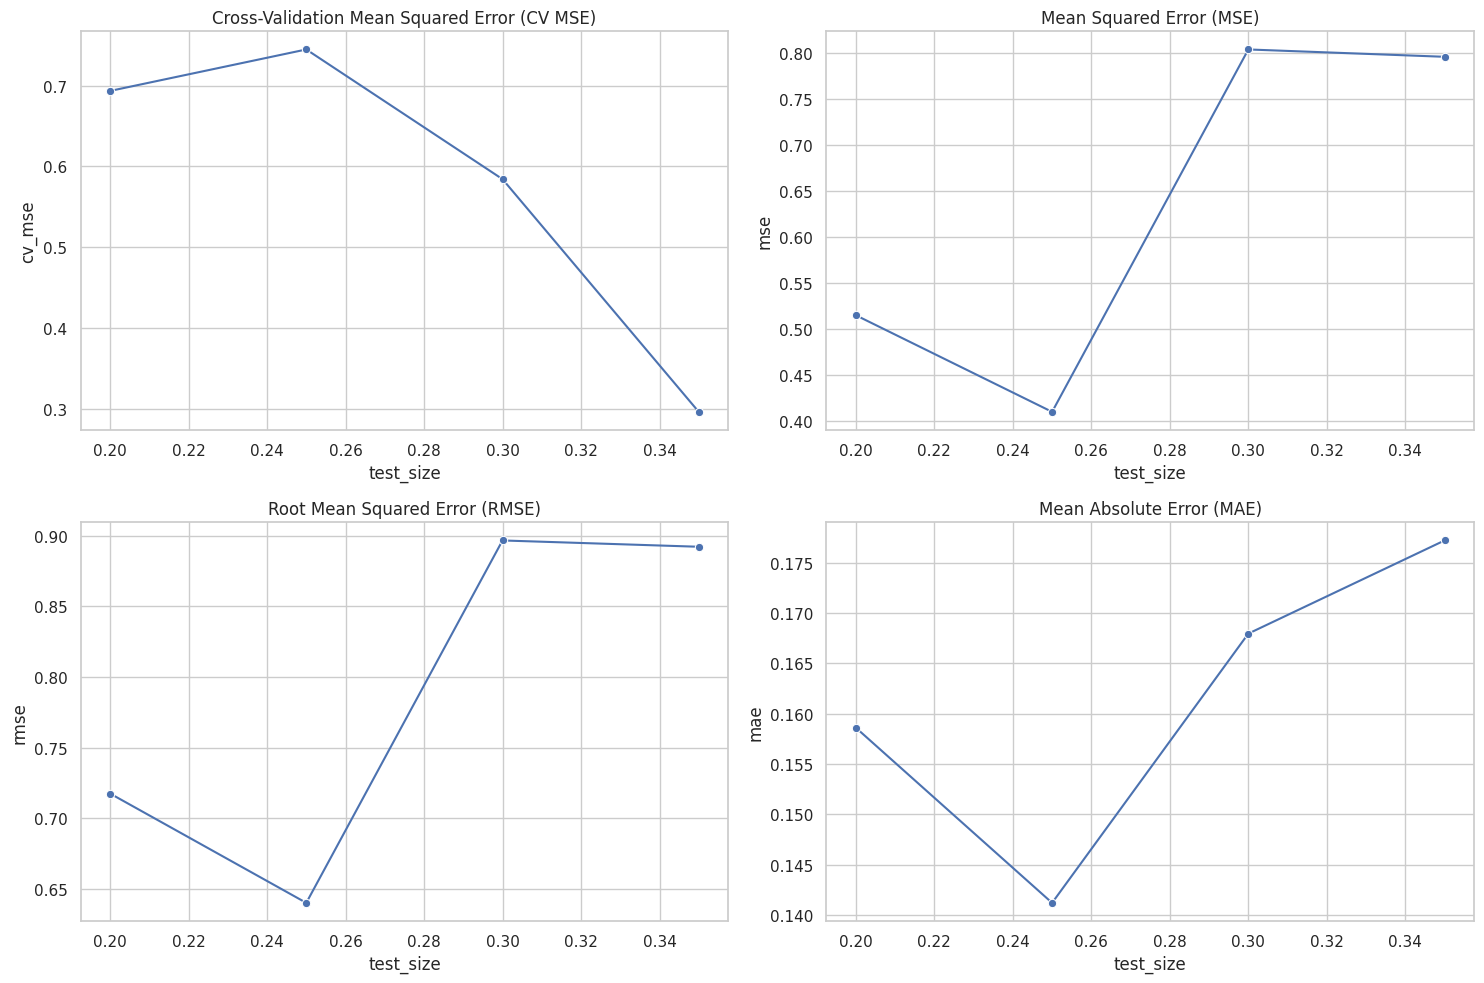

In [29]:
# Load the results
results_df = pd.read_csv('01.Dataset-Rofiqul/016_xgboost_crossval_evaluation_results.csv')

# Set the style of the visualization
sns.set(style="whitegrid")

# Create a figure and a set of subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot Cross-Validation MSE
sns.lineplot(x='test_size', y='cv_mse', data=results_df, marker='o', ax=axs[0, 0])
axs[0, 0].set_title('Cross-Validation Mean Squared Error (CV MSE)')

# Plot MSE
sns.lineplot(x='test_size', y='mse', data=results_df, marker='o', ax=axs[0, 1])
axs[0, 1].set_title('Mean Squared Error (MSE)')

# Plot RMSE
sns.lineplot(x='test_size', y='rmse', data=results_df, marker='o', ax=axs[1, 0])
axs[1, 0].set_title('Root Mean Squared Error (RMSE)')

# Plot MAE
sns.lineplot(x='test_size', y='mae', data=results_df, marker='o', ax=axs[1, 1])
axs[1, 1].set_title('Mean Absolute Error (MAE)')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

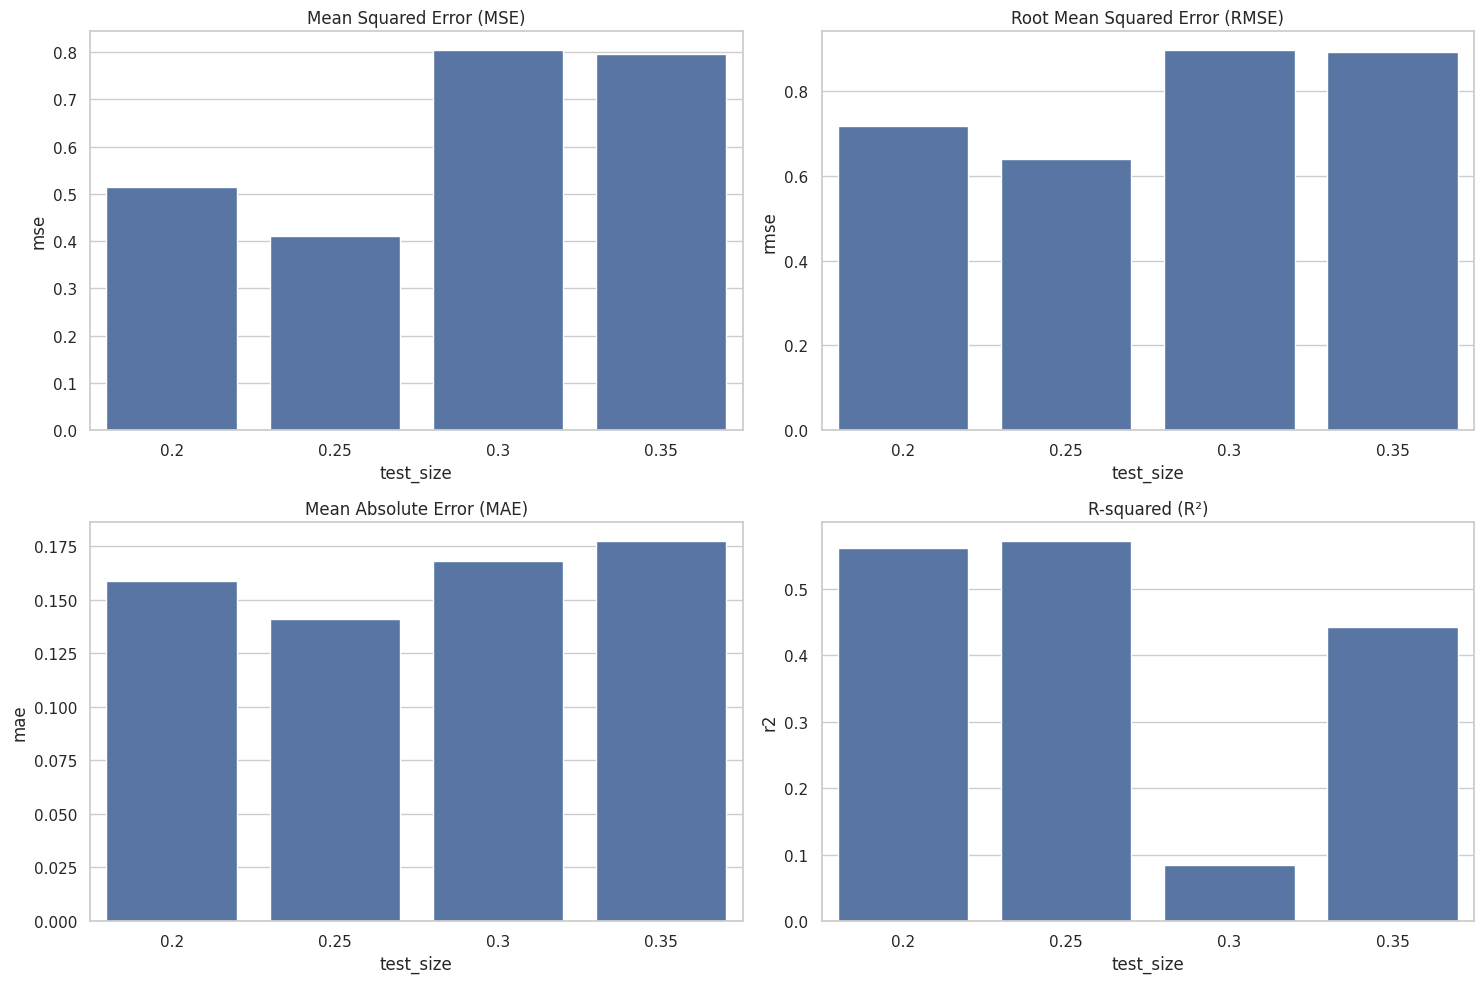

In [31]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
# Plot MSE
sns.barplot(x='test_size', y='mse', data=results_df, ax=axs[0, 0])
axs[0, 0].set_title('Mean Squared Error (MSE)')

# Plot RMSE
sns.barplot(x='test_size', y='rmse', data=results_df, ax=axs[0, 1])
axs[0, 1].set_title('Root Mean Squared Error (RMSE)')

# Plot MAE
sns.barplot(x='test_size', y='mae', data=results_df, ax=axs[1, 0])
axs[1, 0].set_title('Mean Absolute Error (MAE)')

# Plot R-squared
sns.barplot(x='test_size', y='r2', data=results_df, ax=axs[1, 1])
axs[1, 1].set_title('R-squared (R²)')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

## Best Evaluation

In [34]:
# Find the model with the lowest MSE
best_mse_model = results_df.loc[results_df['mse'].idxmin()]

# Find the model with the highest R-squared
best_r2_model = results_df.loc[results_df['r2'].idxmax()]

# Print the best models
print("Best Model Based on Lowest MSE:")
print(best_mse_model)

print("\nBest Model Based on Highest R-squared:")
print(best_r2_model)

Best Model Based on Lowest MSE:
test_size    0.250000
cv_mse       0.744706
mse          0.409857
rmse         0.640201
mae          0.141192
r2           0.571203
Name: 1, dtype: float64

Best Model Based on Highest R-squared:
test_size    0.250000
cv_mse       0.744706
mse          0.409857
rmse         0.640201
mae          0.141192
r2           0.571203
Name: 1, dtype: float64


In [37]:
# Identify the best evaluation based on the lowest MSE
best_evaluation_mse = results_df.loc[results_df['mse'].idxmin()]

# Identify the best evaluation based on the lowest RMSE
best_evaluation_rmse = results_df.loc[results_df['rmse'].idxmin()]

# Identify the best evaluation based on the lowest MAE
best_evaluation_mae = results_df.loc[results_df['mae'].idxmin()]

# Identify the best evaluation based on the highest R²
best_evaluation_r2 = results_df.loc[results_df['r2'].idxmax()]

# Normalize the metrics for comparison
results_df['mse_norm'] = results_df['mse'] / results_df['mse'].max()
results_df['rmse_norm'] = results_df['rmse'] / results_df['rmse'].max()
results_df['mae_norm'] = results_df['mae'] / results_df['mae'].max()
results_df['r2_norm'] = results_df['r2'] / results_df['r2'].max()

# Calculate a composite score (lower is better for mse, rmse, and mae; higher is better for r2)
results_df['composite_score'] = (results_df['mse_norm'] + results_df['rmse_norm'] + results_df['mae_norm'] - results_df['r2_norm'])

# Identify the best overall test size based on the composite score
best_overall_evaluation = results_df.loc[results_df['composite_score'].idxmin()]

# Print the best evaluation results
print("Best Evaluation Result Based on MSE:")
print(best_evaluation_mse)

print("\nBest Evaluation Result Based on RMSE:")
print(best_evaluation_rmse)

print("\nBest Evaluation Result Based on MAE:")
print(best_evaluation_mae)

print("\nBest Evaluation Result Based on R²:")
print(best_evaluation_r2)

print("\nBest Overall Evaluation Result Based on Composite Score:")
print(best_overall_evaluation)

Best Evaluation Result Based on MSE:
test_size          0.250000
cv_mse             0.744706
mse                0.409857
rmse               0.640201
mae                0.141192
r2                 0.571203
mse_norm           0.509742
rmse_norm          0.713962
mae_norm           0.796652
r2_norm            1.000000
composite_score    1.020355
Name: 1, dtype: float64

Best Evaluation Result Based on RMSE:
test_size          0.250000
cv_mse             0.744706
mse                0.409857
rmse               0.640201
mae                0.141192
r2                 0.571203
mse_norm           0.509742
rmse_norm          0.713962
mae_norm           0.796652
r2_norm            1.000000
composite_score    1.020355
Name: 1, dtype: float64

Best Evaluation Result Based on MAE:
test_size          0.250000
cv_mse             0.744706
mse                0.409857
rmse               0.640201
mae                0.141192
r2                 0.571203
mse_norm           0.509742
rmse_norm          0.71396

## Define GridSearch and RandomSearch Optimization Parameters

In [30]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5]
}

# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 2, 3, 4, 5, 6]
}


In [31]:

#Implement a function to perform hyperparameter tuning using GridSearchCV and RandomizedSearchCV
def hyperparameter_tuning(X_train, y_train, method='grid'):
    # Initialize the XGBoost model
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

    if method == 'grid':
        # GridSearchCV
        grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
    elif method == 'random':
        # RandomizedSearchCV
        random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, n_iter=100, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1, random_state=42)
        random_search.fit(X_train, y_train)
        best_model = random_search.best_estimator_
        best_params = random_search.best_params_

    return best_model, best_params

#Train and evaluate the model for different test sizes 
def train_evaluate_tuning(test_size, tuning_method='grid'):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # Perform hyperparameter tuning
    best_model, best_params = hyperparameter_tuning(X_train, y_train, method=tuning_method)

    # Make predictions on the test set
    y_pred = best_model.predict(X_test)

    # Evaluate the model's performance
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Test Size: {test_size}, Tuning Method: {tuning_method}")
    print(f"Best Parameters: {best_params}")
    print(f"Mean Squared Error: {mse}")
    print(f"Root Mean Squared Error: {rmse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"R-squared: {r2}")

    # Plot the actual vs predicted values
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_test, y=y_pred)
    plt.xlabel('Actual N2O')
    plt.ylabel('Predicted N2O')
    plt.title(f'Actual vs Predicted N2O (Test Size: {test_size}, Tuning Method: {tuning_method})')
    plt.show()

    # Plot residuals
    residuals = y_test - y_pred
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True)
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title(f'Residuals Distribution (Test Size: {test_size}, Tuning Method: {tuning_method})')
    plt.show()

    return best_model, mse, rmse, mae, r2


In [33]:

#Compare the results across different test sizes and tuning methods
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

test_sizes = [0.2, 0.25, 0.3, 0.35]
tuning_methods = ['grid', 'random']
results = {}

for test_size in test_sizes:
    for method in tuning_methods:
        model, mse, rmse, mae, r2 = train_evaluate_tuning(test_size, tuning_method=method)
        results[(test_size, method)] = {'model': model, 'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2}

# Display the results
for key, metrics in results.items():
    test_size, method = key
    print(f"Test Size: {test_size}, Tuning Method: {method}")
    print(f"Mean Squared Error: {metrics['mse']}")
    print(f"Root Mean Squared Error: {metrics['rmse']}")
    print(f"Mean Absolute Error: {metrics['mae']}")
    print(f"R-squared: {metrics['r2']}")
    print("\n")



Fitting 3 folds for each of 729 candidates, totalling 2187 fits


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.0

KeyboardInterrupt: 